This is an example notebook for CNN peak classification model with different input features (i.e. 3 dimension or 5 dimension or multi input model)

In [1]:
import logging
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
%load_ext autoreload

In [2]:
import pandas as pd
import os
import sys
import numpy as np

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-03-08 13:23:34,435 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-08 13:23:34,436 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Load Data

In [3]:
# experiment specific
result_base_dir = "collinear_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist"

In [4]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
result_dir = os.path.join(result_parent_dir, result_base_dir)
report_dir = os.path.join(result_dir, "report")
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)
output_file = os.path.join(result_dir, "output")  # filename
maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [5]:
# Load data
ms1scans_no_array = pd.read_csv(MS1Scans_NoArray_path)
ms1scans_no_array["scan_number"] = ms1scans_no_array.index.astype(int)
maxquant_result_ref = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_ref.index = maxquant_result_ref["id"]
maxquant_result_exp = pd.read_csv(filepath_or_buffer=maxquant_file_exp, sep="\t")
scan_record = pd.read_pickle(output_file + "_scan_record.pkl")
sum_raw = pd.read_csv(os.path.join(result_dir, "sum_raw.csv"))
sum_minima = pd.read_csv(os.path.join(result_dir, "sum_minima.csv"))
sum_gaussian = pd.read_csv(os.path.join(result_dir, "sum_gaussian.csv"))
sum_peak = pd.read_csv(os.path.join(result_dir, "sum_peak.csv"))
peak_results = pd.read_csv(os.path.join(result_dir, "peak_results.csv"))
peak_results_matched = pd.read_csv(os.path.join(result_dir, "peak_results_matched.csv"))

# Exploratory analysis
## Does RT search window covers true elution peak?

In [7]:
%autoreload 2
from result_analysis import result_analysis
sbs_result = result_analysis.SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_exp_df=maxquant_result_exp,
    sum_raw=sum_raw,
)

2024-03-08 13:23:54,190 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64


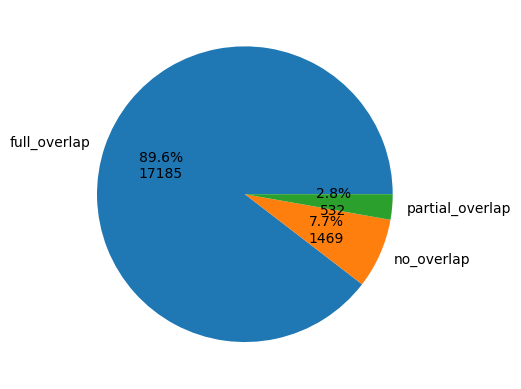

2024-03-08 13:23:55,215 - result_analysis.result_analysis - INFO - No filter_by_rt_overlap is specified, use all entries for plotting.
2024-03-08 13:23:55,228 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 19186 -> 18753


In [8]:
sbs_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=None, handle_mul_exp_pcm="drop", save_dir=None
)

In [9]:
merged_df = sbs_result.ref_exp_df_inner

## Peak stats from activation peak extraction

In [10]:
peak_results_matched.matched.value_counts(normalize=False)

False    63781
True     18020
Name: matched, dtype: int64

In [12]:
peak_results_matched["peak_intensity_auc_log"] = np.round(
    np.log10(peak_results_matched["peak_intensity_auc"] + 1), 0
)
peak_results_matched["RT_diff_sum_round"] = np.round(
    peak_results_matched["RT_diff_sum"], 1
)

In [13]:
%autoreload 2
from postprocessing.peak_selection import report_peak_property_distr
report_peak_property_distr(peak_results_matched, property_col="peak_width", save_dir=report_dir)

2024-03-08 13:24:02.946098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 13:24:14.907980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-08 13:24:45.686388: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-08 13:24:47,101 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

In [14]:
%autoreload 2
from postprocessing.peak_selection import report_peak_property_distr
report_peak_property_distr(peak_results_matched, property_col='peak_intensity_auc_log', save_dir=report_dir)

2024-03-08 13:24:49,300 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-08 13:24:49,349 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


# Data cleaning
## Set peaks that is too far from true peak by time to be false

In [15]:
# set peaks with larget RT_diff_sum to be false
peak_results_matched.loc[
    peak_results_matched["jaccard_similarity"] < 0.5, "matched"
] = False

In [16]:
peak_results_matched[peak_results_matched["matched"]]["RT_diff_sum"].describe()

count    16164.000000
mean         0.035618
std          0.032506
min          0.009305
25%          0.017161
50%          0.018080
75%          0.035005
max          0.682609
Name: RT_diff_sum, dtype: float64

# Data preprocessing
peak_results mark the annotated data:
- matched: binary classification task


## Generate sequence and labels
### Read all feature data

In [17]:
# Load activation sequence
activation = np.load(output_file + "_activationByScanFromLasso.npy")
activation_df = pd.DataFrame(activation, index=maxquant_result_ref.id)

In [18]:
# Load PS cosine distance
cos_dist = np.load(output_file + "_precursor_scan_CosDist.npy")
cos_dist_df = pd.DataFrame(cos_dist, index=maxquant_result_ref.id)

In [20]:
# Load number of collinear sequences
try:
    n_collinear_precursor = np.load(
        output_file + "_n_collinear_precursor.npy", allow_pickle=True
    )
    n_collinear_precursor_df = pd.DataFrame(
        n_collinear_precursor, index=maxquant_result_ref.id
    )
except FileNotFoundError:
    # if file not found, count number of collinear precursors
    collinear_precursor = np.load(
        output_file + "_collinearPrecursors.npy", allow_pickle=True
    )

    # Function to get length of list or 0
    vectorized_length = np.vectorize(lambda x: len(x) if isinstance(x, list) else 0)

    # Apply function to ndarray
    n_collinear_precursor = vectorized_length(collinear_precursor)
    np.save(output_file + "_n_collinear_precursor.npy", n_collinear_precursor)

In [21]:
peak_results_matched_search_range = pd.merge(
    left=peak_results_matched.reset_index(),
    right=maxquant_result_ref[
        ["RT_search_left", "RT_search_right", "RT_search_center"]
    ],
    right_index=True,
    left_on="id",
    how="left",
)

### Prepare sequence and label for each feature

2024-03-08 13:25:23,825 - postprocessing.peak_selection - INFO - Match time to scan for the peak results dataframe.
2024-03-08 13:25:34,042 - postprocessing.peak_selection - INFO - Padded sequence shape: (81801, 361)
2024-03-08 13:25:34,045 - postprocessing.peak_selection - INFO - Sequence shape: (81801, 361)
2024-03-08 13:25:34,046 - postprocessing.peak_selection - INFO - Label shape: (81801,)


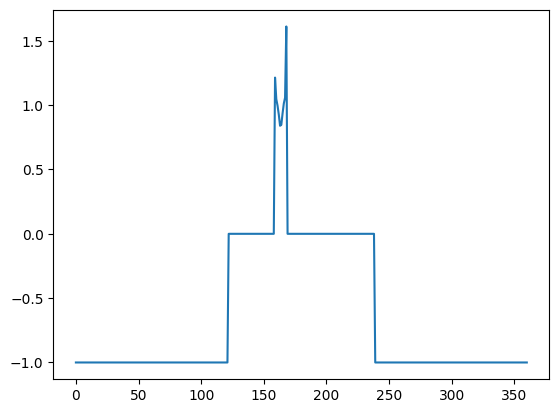

In [22]:
import matplotlib.pyplot as plt
from postprocessing.peak_selection import prepare_seq_and_label

cos_dist_seq, cos_dist_label = prepare_seq_and_label(
    peak_results=peak_results_matched_search_range,
    activation_df=cos_dist_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    log_intensity=False,
)
plt.plot(cos_dist_seq[1])

In [23]:
scan_index = np.tile(activation_df.columns.values, (activation_df.shape[0], 1))
scan_index_df = pd.DataFrame(
    scan_index, index=activation_df.index, columns=activation_df.columns
)
scan_index_df = scan_index_df.astype(float)
scan_index_seq, scan_index_label = prepare_seq_and_label(
    peak_results=peak_results_matched_search_range,
    activation_df=scan_index_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    log_intensity=False,
)

2024-03-07 14:49:57,609 - postprocessing.peak_selection - INFO - Padded sequence shape: (81801, 361)
2024-03-07 14:49:57,612 - postprocessing.peak_selection - INFO - Sequence shape: (81801, 361)
2024-03-07 14:49:57,613 - postprocessing.peak_selection - INFO - Label shape: (81801,)


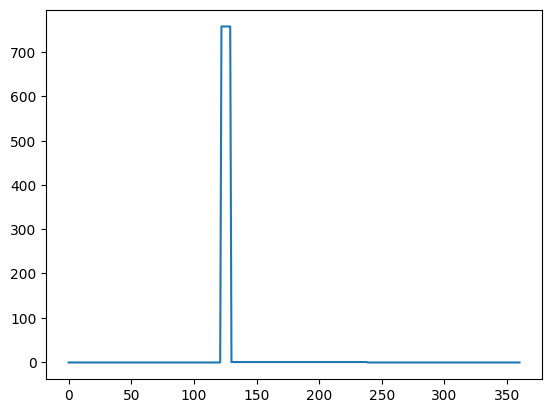

In [25]:
from utils.tools import match_time_to_scan

maxquant_result_ref = match_time_to_scan(
    df=maxquant_result_ref,
    ms1scans_no_array=ms1scans_no_array,
    time_cols=["RT_search_center"],
)
rt_search_center_scan_df = pd.DataFrame(
    index=activation_df.index, columns=activation_df.columns
)
rt_search_center_scan_df = rt_search_center_scan_df.apply(
    lambda _: maxquant_result_ref["RT_search_center_scan"]
)
rt_search_center_scan_df = rt_search_center_scan_df.astype(float)
rt_search_center_scan_seq, rt_search_center_scan_label = prepare_seq_and_label(
    peak_results=peak_results_matched_search_range,
    activation_df=rt_search_center_scan_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    log_intensity=False,
)
plt.plot(rt_search_center_scan_seq[0])

In [23]:
n_collinear_precursor_df = n_collinear_precursor_df.astype(float)
colliear_seq, _ = prepare_seq_and_label(
    peak_results=peak_results_matched_search_range,
    activation_df=n_collinear_precursor_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize=None,
    pad=True,
    log_intensity=False,
)

2024-03-08 13:27:06,055 - postprocessing.peak_selection - INFO - Padded sequence shape: (81801, 361)
2024-03-08 13:27:06,056 - postprocessing.peak_selection - INFO - Sequence shape: (81801, 361)
2024-03-08 13:27:06,057 - postprocessing.peak_selection - INFO - Label shape: (81801,)


2024-03-08 13:27:25,785 - postprocessing.peak_selection - INFO - Padded sequence shape: (81801, 361)
2024-03-08 13:27:25,788 - postprocessing.peak_selection - INFO - Sequence shape: (81801, 361)
2024-03-08 13:27:25,789 - postprocessing.peak_selection - INFO - Label shape: (81801,)


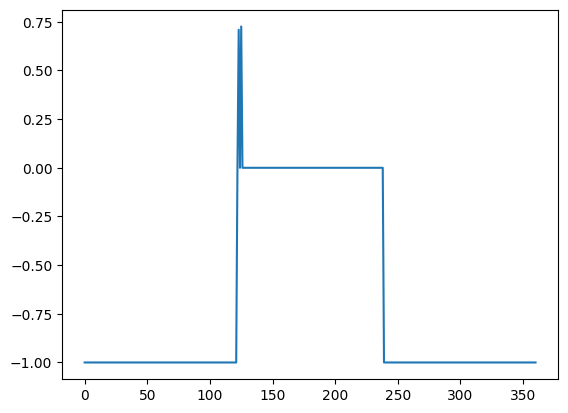

In [24]:
peak_seq, peak_label = prepare_seq_and_label(
    peak_results=peak_results_matched_search_range,
    activation_df=activation_df,
    data_unit="peak",
    ms1scans_no_array=ms1scans_no_array,
    standardize="minmax",
    pad=True,
    log_intensity=True,
)
plt.plot(peak_seq[0])

### Stack all features together as input
Choose what features to be incorporated: 3d or 5d input

In [25]:
peak_seq_3d_input = np.dstack((peak_seq, cos_dist_seq, colliear_seq))

In [ ]:
peak_seq_5d_input = np.dstack(
    (peak_seq, cos_dist_seq, colliear_seq,
     scan_index_seq, rt_search_center_scan_seq)
)

## (Optional) for multi-input model: genearte metadata

In [ ]:
delta_rt = peak_results_matched_search_range["rt_search_center_diff"].values
metadata_input = delta_rt.reshape(-1, 1)

In [ ]:
# min_max scale within each precursor
from sklearn.preprocessing import MinMaxScaler

# Group by 'id'
grouped = peak_results_matched_search_range.groupby("id")

# Calculate group minimum and range
group_min = grouped["rt_search_center_diff"].transform("min")
group_range = grouped["rt_search_center_diff"].transform("max") - group_min

In [ ]:
# Perform min-max scaling
peak_results_matched_search_range["rt_search_center_diff_scaled"] = (
    peak_results_matched_search_range["rt_search_center_diff"] - group_min
) / group_range

In [ ]:
peak_results_matched_search_range["rt_search_center_diff_scaled"].fillna(
    0, inplace=True
)

In [ ]:
peak_results_matched_search_range["rt_search_center_diff_scaled"].describe()

count    81801.000000
mean         0.474221
std          0.381141
min          0.000000
25%          0.064794
50%          0.454340
75%          0.858651
max          1.000000
Name: rt_search_center_diff_scaled, dtype: float64

In [ ]:
peak_results_matched_search_range.loc[
    0:20, ["id", "rt_search_center_diff", "rt_search_center_diff_scaled"]
]

,id,rt_search_center_diff,rt_search_center_diff_scaled
0,19,0.941114,1.000000
1,19,0.289034,0.000000
2,32,0.849468,0.837050
3,32,0.814868,0.797076
4,32,0.471413,0.400264
5,32,0.124970,0.000000
6,32,0.183751,0.067913
7,32,0.355877,0.266779
8,32,0.681120,0.642549
9,32,0.870063,0.860845


In [ ]:
delta_rt = peak_results_matched_search_range["rt_search_center_diff_scaled"].values
metadata_input = delta_rt.reshape(-1, 1)

## Split Data

In [116]:
from postprocessing.peak_selection import split_data

(train_indices, val_indices, test_indices) = split_data(
    seq=peak_seq_3d_input,
    test_ratio=0.2,
    val_ratio=0.1,
    random_seed=42,
    precursor_id=peak_results_matched_search_range.id,
)
peak_seq_train = peak_seq_3d_input[train_indices]
peak_seq_test = peak_seq_3d_input[test_indices]
peak_label_train = peak_label[train_indices]
peak_label_test = peak_label[test_indices]
metadata_input_train = metadata_input[train_indices]
metadata_input_test = metadata_input[test_indices]
metadata_input_val = metadata_input[val_indices]
peak_seq_val = peak_seq_3d_input[val_indices]
peak_label_val = peak_label[val_indices]

2024-03-08 15:23:08,610 - postprocessing.peak_selection - INFO - Split data by precursor id.


In [117]:
train_neg = peak_label_train.shape[0] - peak_label_train.sum()

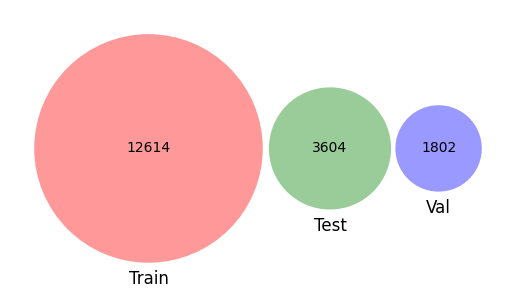

In [118]:
# Validate splitting by precursor id
from matplotlib_venn import venn3

train_precursor = peak_results_matched_search_range.loc[train_indices, "id"]
test_precursor = peak_results_matched_search_range.loc[test_indices, "id"]
val_precursor = peak_results_matched_search_range.loc[val_indices, "id"]
venn3(
    subsets=(set(train_precursor), set(test_precursor), set(val_precursor)),
    set_labels=("Train", "Test", "Val"),
)

## Data Imbalance

### calculate class bias

In [ ]:
from postprocessing.peak_selection import evaluate_class_distribution

initial_bias, class_weight, initial_distr = evaluate_class_distribution(
    peak_label)

2024-03-08 13:34:33,197 - postprocessing.peak_selection - INFO - Class distribution: 0    65637
1    16164
dtype: int64


### rejection sampling to balance data

In [121]:
# preparation of input dataset is done differently based on how the data is fed into the model
import tensorflow as tf

tf.random.set_seed(42)

model = "multi_input"  # model = "multi_input" or "cnn"
match model:
    case "multi_input":

        def multi_input_generator(peak_seq, metadata_input, peak_label):
            def generator():
                for peak, meta, label in zip(peak_seq, metadata_input, peak_label):
                    yield {"peak_seq": peak, "metadata": meta}, label

            dataset = tf.data.Dataset.from_generator(
                generator,
                output_types=(
                    {"peak_seq": tf.float32, "metadata": tf.float32},
                    tf.int32,
                ),
            )
            return dataset

        train_dataset = multi_input_generator(
            peak_seq_train, metadata_input_train, peak_label_train
        )
        val_dataset = multi_input_generator(
            peak_seq_val, metadata_input_val, peak_label_val
        )
        test_dataset = multi_input_generator(
            peak_seq_test, metadata_input_test, peak_label_test
        )
    case "cnn":
        # No multi_input
        train_dataset = tf.data.Dataset.from_tensor_slices(
            (peak_seq_train, peak_label_train)
        )
        val_dataset = tf.data.Dataset.from_tensor_slices(
            (peak_seq_val, peak_label_val))
        test_dataset = tf.data.Dataset.from_tensor_slices(
            (peak_seq_test, peak_label_test)
        )

In [122]:
val_dataset_batch = val_dataset.batch(2048, drop_remainder=False)
test_dataset_batch = test_dataset.batch(2048, drop_remainder=False)

In [123]:
# Make dataset by rejection resampling
train_dataset_balanced = train_dataset.rejection_resample(
    class_func=lambda x, y: y,
    target_dist=[0.5, 0.5],
    initial_dist=initial_distr,
)
train_dataset_balanced = train_dataset_balanced.map(
    lambda class_func_result, data: data
)

# sanitiy check
print(len(list(train_dataset_balanced)))
train_dataset_batch = train_dataset_balanced.batch(1024, drop_remainder=False)


for features, label in train_dataset_batch.take(1):
    print(label.numpy().mean())

2024-03-08 15:23:25.757494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-03-08 15:23:25.757959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.8

29929


2024-03-08 15:23:59.931003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype float and shape [2]
	 [[{{node Placeholder/_18}}]]
2024-03-08 15:23:59.931566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler

0.4853515625


# Model building and training
## set model config

In [124]:
from postprocessing.peak_selection import make_cnn_model

cnn_config = {
    "conv1_n_filters": 32,
    "conv1_kernel_size": 3,
    "conv1_strides": 1,
    "conv2_n_filters": 64,
    "conv2_kernel_size": 3,
    "conv2_strides": 1,
    "conv3_n_filters": 128,
    "conv3_kernel_size": 3,
    "conv3_strides": 1,
    "dense1_n_units": 128,
    "dense1_reg_rate": None,
    "dense2_n_units": 64,
    "dense2_reg_rate": None,
    "dense3_n_units": 32,
    "dense3_reg_rate": None,
    "dropout_rate": 0.0,
    "learning_rate": 0.01,
    "metadata_input_shape": metadata_input_train.shape[1],
    "peak_seq_features": peak_seq_train.shape[2],
    "peak_seq_maxlen": peak_seq_train.shape[1],
}

In [125]:
match model:
    case "cnn":
        cnn_model = make_cnn_model(config=cnn_config, output_bias=None)
        epochs = 1
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001
        )

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
        history = cnn_model.fit(
            train_dataset_batch,
            epochs=epochs,
            validation_data=val_dataset_batch,
            callbacks=[early_stopping, lr_callback],
            # class_weight=class_weight,
        )
    case "multi_input":
        from postprocessing.peak_selection import make_multi_input_model

        multi_cnn_model = make_multi_input_model(
            config=cnn_config, output_bias=None)
        # plot_model(multi_cnn_model, to_file="multi_cnn_model.png", show_shapes=True)
        epochs = 150
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.1, patience=3, min_lr=0.0001
        )

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
        history = multi_cnn_model.fit(
            train_dataset_batch,
            epochs=epochs,
            validation_data=val_dataset_batch,
            callbacks=[early_stopping, lr_callback],
            # class_weight=class_weight,
        )

Epoch 1/150


2024-03-08 15:24:05.941391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype float and shape [2]
	 [[{{node Placeholder/_18}}]]
2024-03-08 15:24:05.941894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype float and shape [2]
	 [[{{node Placeholder/_18}}]]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejec

     30/Unknown - 30s 890ms/step - loss: 1.1625 - cross entropy: 0.6369 - Brier score: 0.2208 - tp: 9679.0000 - fp: 4759.0000 - tn: 10159.0000 - fn: 5332.0000 - accuracy: 0.6628 - precision: 0.6704 - recall: 0.6448 - auc: 0.7049 - prc: 0.7001

2024-03-08 15:24:36.409925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 34s 1s/step - loss: 1.1625 - cross entropy: 0.6369 - Brier score: 0.2208 - tp: 9679.0000 - fp: 4759.0000 - tn: 10159.0000 - fn: 5332.0000 - accuracy: 0.6628 - precision: 0.6704 - recall: 0.6448 - auc: 0.7049 - prc: 0.7001 - val_loss: 0.6280 - val_cross entropy: 0.5349 - val_Brier score: 0.1658 - val_tp: 1217.0000 - val_fp: 1269.0000 - val_tn: 5277.0000 - val_fn: 377.0000 - val_accuracy: 0.7978 - val_precision: 0.4895 - val_recall: 0.7635 - val_auc: 0.8466 - val_prc: 0.4846 - lr: 0.0100
Epoch 2/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 959ms/step - loss: 0.5446 - cross entropy: 0.4828 - Brier score: 0.1507 - tp: 12408.0000 - fp: 3433.0000 - tn: 11485.0000 - fn: 2603.0000 - accuracy: 0.7983 - precision: 0.7833 - recall: 0.8266 - auc: 0.8618 - prc: 0.8075 - val_loss: 0.4065 - val_cross entropy: 0.3493 - val_Brier score: 0.1074 - val_tp: 1193.0000 - val_fp: 877.0000 - val_tn: 5669.0000 - val_fn: 401.0000 - val_accuracy: 0.8430 - val_precision: 0.5763 - val_recall: 0.7484 - val_auc: 0.9011 - val_prc: 0.6035 - lr: 0.0100
Epoch 3/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 925ms/step - loss: 0.4343 - cross entropy: 0.3787 - Brier score: 0.1143 - tp: 13311.0000 - fp: 2823.0000 - tn: 12095.0000 - fn: 1700.0000 - accuracy: 0.8489 - precision: 0.8250 - recall: 0.8867 - auc: 0.9071 - prc: 0.8636 - val_loss: 0.3538 - val_cross entropy: 0.3048 - val_Brier score: 0.0902 - val_tp: 1109.0000 - val_fp: 520.0000 - val_tn: 6026.0000 - val_fn: 485.0000 - val_accuracy: 0.8765 - val_precision: 0.6808 - val_recall: 0.6957 - val_auc: 0.9253 - val_prc: 0.6739 - lr: 0.0100
Epoch 4/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 924ms/step - loss: 0.3906 - cross entropy: 0.3447 - Brier score: 0.1030 - tp: 13538.0000 - fp: 2608.0000 - tn: 12310.0000 - fn: 1473.0000 - accuracy: 0.8636 - precision: 0.8385 - recall: 0.9019 - auc: 0.9207 - prc: 0.8830 - val_loss: 0.3403 - val_cross entropy: 0.2980 - val_Brier score: 0.0890 - val_tp: 1219.0000 - val_fp: 613.0000 - val_tn: 5933.0000 - val_fn: 375.0000 - val_accuracy: 0.8786 - val_precision: 0.6654 - val_recall: 0.7647 - val_auc: 0.9303 - val_prc: 0.6852 - lr: 0.0100
Epoch 5/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 944ms/step - loss: 0.3681 - cross entropy: 0.3267 - Brier score: 0.0982 - tp: 13612.0000 - fp: 2534.0000 - tn: 12384.0000 - fn: 1399.0000 - accuracy: 0.8686 - precision: 0.8431 - recall: 0.9068 - auc: 0.9276 - prc: 0.8938 - val_loss: 0.3304 - val_cross entropy: 0.2912 - val_Brier score: 0.0890 - val_tp: 1319.0000 - val_fp: 731.0000 - val_tn: 5815.0000 - val_fn: 275.0000 - val_accuracy: 0.8764 - val_precision: 0.6434 - val_recall: 0.8275 - val_auc: 0.9348 - val_prc: 0.6957 - lr: 0.0100
Epoch 6/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 950ms/step - loss: 0.3569 - cross entropy: 0.3195 - Brier score: 0.0964 - tp: 13661.0000 - fp: 2557.0000 - tn: 12361.0000 - fn: 1350.0000 - accuracy: 0.8695 - precision: 0.8423 - recall: 0.9101 - auc: 0.9309 - prc: 0.8999 - val_loss: 0.3033 - val_cross entropy: 0.2673 - val_Brier score: 0.0822 - val_tp: 1297.0000 - val_fp: 654.0000 - val_tn: 5892.0000 - val_fn: 297.0000 - val_accuracy: 0.8832 - val_precision: 0.6648 - val_recall: 0.8137 - val_auc: 0.9384 - val_prc: 0.7107 - lr: 0.0100
Epoch 7/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 941ms/step - loss: 0.3540 - cross entropy: 0.3188 - Brier score: 0.0965 - tp: 13652.0000 - fp: 2555.0000 - tn: 12363.0000 - fn: 1359.0000 - accuracy: 0.8692 - precision: 0.8424 - recall: 0.9095 - auc: 0.9307 - prc: 0.8995 - val_loss: 0.3437 - val_cross entropy: 0.3077 - val_Brier score: 0.0951 - val_tp: 1427.0000 - val_fp: 903.0000 - val_tn: 5643.0000 - val_fn: 167.0000 - val_accuracy: 0.8686 - val_precision: 0.6124 - val_recall: 0.8952 - val_auc: 0.9402 - val_prc: 0.7127 - lr: 0.0100
Epoch 8/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 914ms/step - loss: 0.3435 - cross entropy: 0.3097 - Brier score: 0.0937 - tp: 13724.0000 - fp: 2520.0000 - tn: 12398.0000 - fn: 1287.0000 - accuracy: 0.8728 - precision: 0.8449 - recall: 0.9143 - auc: 0.9349 - prc: 0.9055 - val_loss: 0.3149 - val_cross entropy: 0.2815 - val_Brier score: 0.0877 - val_tp: 1398.0000 - val_fp: 818.0000 - val_tn: 5728.0000 - val_fn: 196.0000 - val_accuracy: 0.8754 - val_precision: 0.6309 - val_recall: 0.8770 - val_auc: 0.9419 - val_prc: 0.7207 - lr: 0.0100
Epoch 9/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 957ms/step - loss: 0.3419 - cross entropy: 0.3088 - Brier score: 0.0935 - tp: 13738.0000 - fp: 2509.0000 - tn: 12409.0000 - fn: 1273.0000 - accuracy: 0.8736 - precision: 0.8456 - recall: 0.9152 - auc: 0.9351 - prc: 0.9061 - val_loss: 0.3270 - val_cross entropy: 0.2937 - val_Brier score: 0.0916 - val_tp: 1421.0000 - val_fp: 870.0000 - val_tn: 5676.0000 - val_fn: 173.0000 - val_accuracy: 0.8719 - val_precision: 0.6203 - val_recall: 0.8915 - val_auc: 0.9424 - val_prc: 0.7221 - lr: 0.0100
Epoch 10/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 958ms/step - loss: 0.3292 - cross entropy: 0.2968 - Brier score: 0.0894 - tp: 13780.0000 - fp: 2423.0000 - tn: 12495.0000 - fn: 1231.0000 - accuracy: 0.8779 - precision: 0.8505 - recall: 0.9180 - auc: 0.9407 - prc: 0.9147 - val_loss: 0.3549 - val_cross entropy: 0.3229 - val_Brier score: 0.1020 - val_tp: 1474.0000 - val_fp: 1108.0000 - val_tn: 5438.0000 - val_fn: 120.0000 - val_accuracy: 0.8491 - val_precision: 0.5709 - val_recall: 0.9247 - val_auc: 0.9429 - val_prc: 0.7245 - lr: 1.0000e-03
Epoch 11/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 935ms/step - loss: 0.3284 - cross entropy: 0.2964 - Brier score: 0.0896 - tp: 13807.0000 - fp: 2457.0000 - tn: 12461.0000 - fn: 1204.0000 - accuracy: 0.8777 - precision: 0.8489 - recall: 0.9198 - auc: 0.9408 - prc: 0.9153 - val_loss: 0.3581 - val_cross entropy: 0.3263 - val_Brier score: 0.1035 - val_tp: 1484.0000 - val_fp: 1133.0000 - val_tn: 5413.0000 - val_fn: 110.0000 - val_accuracy: 0.8473 - val_precision: 0.5671 - val_recall: 0.9310 - val_auc: 0.9434 - val_prc: 0.7266 - lr: 1.0000e-03
Epoch 11: early stopping


In [173]:
# if desired, resume traing with new learning rate setting
epochs = 150
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=3, min_lr=0.000001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", verbose=1, patience=5, mode="min", restore_best_weights=True
)
history_newlr = multi_cnn_model.fit(
    train_dataset_batch,
    epochs=epochs,
    validation_data=val_dataset_batch,
    callbacks=[early_stopping, lr_callback],
    # class_weight=class_weight,
)

Epoch 1/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 938ms/step - loss: 0.3213 - cross entropy: 0.2897 - Brier score: 0.0883 - tp: 13755.0000 - fp: 2380.0000 - tn: 12538.0000 - fn: 1256.0000 - accuracy: 0.8785 - precision: 0.8525 - recall: 0.9163 - auc: 0.9441 - prc: 0.9242 - val_loss: 0.3495 - val_cross entropy: 0.3181 - val_Brier score: 0.1014 - val_tp: 1478.0000 - val_fp: 1102.0000 - val_tn: 5444.0000 - val_fn: 116.0000 - val_accuracy: 0.8504 - val_precision: 0.5729 - val_recall: 0.9272 - val_auc: 0.9451 - val_prc: 0.7392 - lr: 1.0000e-04
Epoch 2/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 936ms/step - loss: 0.3205 - cross entropy: 0.2891 - Brier score: 0.0880 - tp: 13837.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1174.0000 - accuracy: 0.8795 - precision: 0.8505 - recall: 0.9218 - auc: 0.9446 - prc: 0.9254 - val_loss: 0.3479 - val_cross entropy: 0.3166 - val_Brier score: 0.1009 - val_tp: 1479.0000 - val_fp: 1099.0000 - val_tn: 5447.0000 - val_fn: 115.0000 - val_accuracy: 0.8509 - val_precision: 0.5737 - val_recall: 0.9279 - val_auc: 0.9452 - val_prc: 0.7399 - lr: 1.0000e-04
Epoch 3/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 933ms/step - loss: 0.3205 - cross entropy: 0.2891 - Brier score: 0.0880 - tp: 13857.0000 - fp: 2452.0000 - tn: 12466.0000 - fn: 1154.0000 - accuracy: 0.8795 - precision: 0.8497 - recall: 0.9231 - auc: 0.9446 - prc: 0.9253 - val_loss: 0.3461 - val_cross entropy: 0.3149 - val_Brier score: 0.1002 - val_tp: 1473.0000 - val_fp: 1086.0000 - val_tn: 5460.0000 - val_fn: 121.0000 - val_accuracy: 0.8517 - val_precision: 0.5756 - val_recall: 0.9241 - val_auc: 0.9453 - val_prc: 0.7402 - lr: 1.0000e-04
Epoch 4/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 950ms/step - loss: 0.3204 - cross entropy: 0.2890 - Brier score: 0.0879 - tp: 13852.0000 - fp: 2450.0000 - tn: 12468.0000 - fn: 1159.0000 - accuracy: 0.8794 - precision: 0.8497 - recall: 0.9228 - auc: 0.9446 - prc: 0.9253 - val_loss: 0.3463 - val_cross entropy: 0.3150 - val_Brier score: 0.1003 - val_tp: 1473.0000 - val_fp: 1087.0000 - val_tn: 5459.0000 - val_fn: 121.0000 - val_accuracy: 0.8516 - val_precision: 0.5754 - val_recall: 0.9241 - val_auc: 0.9453 - val_prc: 0.7398 - lr: 1.0000e-04
Epoch 5/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 954ms/step - loss: 0.3203 - cross entropy: 0.2890 - Brier score: 0.0879 - tp: 13852.0000 - fp: 2447.0000 - tn: 12471.0000 - fn: 1159.0000 - accuracy: 0.8795 - precision: 0.8499 - recall: 0.9228 - auc: 0.9446 - prc: 0.9253 - val_loss: 0.3465 - val_cross entropy: 0.3153 - val_Brier score: 0.1004 - val_tp: 1473.0000 - val_fp: 1088.0000 - val_tn: 5458.0000 - val_fn: 121.0000 - val_accuracy: 0.8515 - val_precision: 0.5752 - val_recall: 0.9241 - val_auc: 0.9453 - val_prc: 0.7398 - lr: 1.0000e-04
Epoch 6/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 928ms/step - loss: 0.3202 - cross entropy: 0.2889 - Brier score: 0.0879 - tp: 13854.0000 - fp: 2449.0000 - tn: 12469.0000 - fn: 1157.0000 - accuracy: 0.8795 - precision: 0.8498 - recall: 0.9229 - auc: 0.9446 - prc: 0.9255 - val_loss: 0.3466 - val_cross entropy: 0.3154 - val_Brier score: 0.1004 - val_tp: 1475.0000 - val_fp: 1089.0000 - val_tn: 5457.0000 - val_fn: 119.0000 - val_accuracy: 0.8516 - val_precision: 0.5753 - val_recall: 0.9253 - val_auc: 0.9453 - val_prc: 0.7401 - lr: 1.0000e-04
Epoch 7/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 935ms/step - loss: 0.3198 - cross entropy: 0.2885 - Brier score: 0.0878 - tp: 13951.0000 - fp: 2516.0000 - tn: 12402.0000 - fn: 1060.0000 - accuracy: 0.8805 - precision: 0.8472 - recall: 0.9294 - auc: 0.9448 - prc: 0.9256 - val_loss: 0.3430 - val_cross entropy: 0.3118 - val_Brier score: 0.0992 - val_tp: 1468.0000 - val_fp: 1071.0000 - val_tn: 5475.0000 - val_fn: 126.0000 - val_accuracy: 0.8529 - val_precision: 0.5782 - val_recall: 0.9210 - val_auc: 0.9454 - val_prc: 0.7413 - lr: 1.0000e-05
Epoch 8/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 939ms/step - loss: 0.3197 - cross entropy: 0.2884 - Brier score: 0.0877 - tp: 13895.0000 - fp: 2479.0000 - tn: 12439.0000 - fn: 1116.0000 - accuracy: 0.8799 - precision: 0.8486 - recall: 0.9257 - auc: 0.9449 - prc: 0.9258 - val_loss: 0.3401 - val_cross entropy: 0.3089 - val_Brier score: 0.0982 - val_tp: 1464.0000 - val_fp: 1053.0000 - val_tn: 5493.0000 - val_fn: 130.0000 - val_accuracy: 0.8547 - val_precision: 0.5816 - val_recall: 0.9184 - val_auc: 0.9454 - val_prc: 0.7414 - lr: 1.0000e-05
Epoch 9/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 946ms/step - loss: 0.3197 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13872.0000 - fp: 2451.0000 - tn: 12467.0000 - fn: 1139.0000 - accuracy: 0.8800 - precision: 0.8498 - recall: 0.9241 - auc: 0.9449 - prc: 0.9261 - val_loss: 0.3390 - val_cross entropy: 0.3078 - val_Brier score: 0.0978 - val_tp: 1462.0000 - val_fp: 1050.0000 - val_tn: 5496.0000 - val_fn: 132.0000 - val_accuracy: 0.8548 - val_precision: 0.5820 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7421 - lr: 1.0000e-05
Epoch 10/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 945ms/step - loss: 0.3196 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13864.0000 - fp: 2444.0000 - tn: 12474.0000 - fn: 1147.0000 - accuracy: 0.8800 - precision: 0.8501 - recall: 0.9236 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3387 - val_cross entropy: 0.3075 - val_Brier score: 0.0977 - val_tp: 1462.0000 - val_fp: 1049.0000 - val_tn: 5497.0000 - val_fn: 132.0000 - val_accuracy: 0.8549 - val_precision: 0.5822 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7419 - lr: 1.0000e-05
Epoch 11/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 915ms/step - loss: 0.3196 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13863.0000 - fp: 2440.0000 - tn: 12478.0000 - fn: 1148.0000 - accuracy: 0.8801 - precision: 0.8503 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3386 - val_cross entropy: 0.3074 - val_Brier score: 0.0977 - val_tp: 1462.0000 - val_fp: 1048.0000 - val_tn: 5498.0000 - val_fn: 132.0000 - val_accuracy: 0.8550 - val_precision: 0.5825 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7420 - lr: 1.0000e-05
Epoch 12/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 920ms/step - loss: 0.3196 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13861.0000 - fp: 2437.0000 - tn: 12481.0000 - fn: 1150.0000 - accuracy: 0.8801 - precision: 0.8505 - recall: 0.9234 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3386 - val_cross entropy: 0.3074 - val_Brier score: 0.0977 - val_tp: 1462.0000 - val_fp: 1047.0000 - val_tn: 5499.0000 - val_fn: 132.0000 - val_accuracy: 0.8552 - val_precision: 0.5827 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-05
Epoch 13/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 930ms/step - loss: 0.3196 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13861.0000 - fp: 2437.0000 - tn: 12481.0000 - fn: 1150.0000 - accuracy: 0.8801 - precision: 0.8505 - recall: 0.9234 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3386 - val_cross entropy: 0.3074 - val_Brier score: 0.0977 - val_tp: 1462.0000 - val_fp: 1047.0000 - val_tn: 5499.0000 - val_fn: 132.0000 - val_accuracy: 0.8552 - val_precision: 0.5827 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7417 - lr: 1.0000e-05
Epoch 14/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 952ms/step - loss: 0.3196 - cross entropy: 0.2883 - Brier score: 0.0877 - tp: 13861.0000 - fp: 2436.0000 - tn: 12482.0000 - fn: 1150.0000 - accuracy: 0.8802 - precision: 0.8505 - recall: 0.9234 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3386 - val_cross entropy: 0.3074 - val_Brier score: 0.0977 - val_tp: 1462.0000 - val_fp: 1047.0000 - val_tn: 5499.0000 - val_fn: 132.0000 - val_accuracy: 0.8552 - val_precision: 0.5827 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-05
Epoch 15/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 936ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2437.0000 - tn: 12481.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8505 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3385 - val_cross entropy: 0.3073 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1047.0000 - val_tn: 5499.0000 - val_fn: 132.0000 - val_accuracy: 0.8552 - val_precision: 0.5827 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 16/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 962ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2437.0000 - tn: 12481.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8505 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3385 - val_cross entropy: 0.3073 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 17/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 937ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2436.0000 - tn: 12482.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8506 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3385 - val_cross entropy: 0.3073 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 18/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 935ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2436.0000 - tn: 12482.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8506 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3385 - val_cross entropy: 0.3073 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 19/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 930ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2436.0000 - tn: 12482.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8506 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3384 - val_cross entropy: 0.3072 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 20/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 934ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13867.0000 - fp: 2435.0000 - tn: 12483.0000 - fn: 1144.0000 - accuracy: 0.8804 - precision: 0.8506 - recall: 0.9238 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3384 - val_cross entropy: 0.3072 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 21/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 930ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13866.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1145.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3384 - val_cross entropy: 0.3072 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 22/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 909ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13866.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1145.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3384 - val_cross entropy: 0.3072 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 23/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 930ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13866.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1145.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3384 - val_cross entropy: 0.3072 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 24/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 922ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13866.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1145.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1046.0000 - val_tn: 5500.0000 - val_fn: 132.0000 - val_accuracy: 0.8553 - val_precision: 0.5829 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 25/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 929ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13866.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1145.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 26/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 956ms/step - loss: 0.3196 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13865.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1146.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9237 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 27/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 947ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13864.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1147.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9236 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9454 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 28/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 924ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13864.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1147.0000 - accuracy: 0.8804 - precision: 0.8507 - recall: 0.9236 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 29/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 933ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13863.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1148.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 30/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 947ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13863.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1148.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 31/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 27s 900ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13863.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1148.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 32/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 924ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13863.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1148.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0976 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 33/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 960ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 34/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 934ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 35/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 954ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3383 - val_cross entropy: 0.3071 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 36/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 927ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3383 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 37/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 917ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2434.0000 - tn: 12484.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8506 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 38/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 946ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 39/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 929ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 40/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 931ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7419 - lr: 1.0000e-06
Epoch 41/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 950ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 42/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 911ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 43/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 956ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 44/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 955ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 45/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 925ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 46/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 936ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 47/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 927ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9261 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 48/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 934ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 49/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 945ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7417 - lr: 1.0000e-06
Epoch 50/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 924ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1045.0000 - val_tn: 5501.0000 - val_fn: 132.0000 - val_accuracy: 0.8554 - val_precision: 0.5832 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 51/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 944ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 52/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 954ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 53/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 948ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 54/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 937ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 55/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 936ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 56/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 944ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 57/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 922ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 58/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 29s 945ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 59/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 923ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 60/150


Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]
Proportion of examples rejected by sampler is high: [0.802398503][0.802398503 0.197601497][0 1]


30/30 [==============================] - 28s 925ms/step - loss: 0.3195 - cross entropy: 0.2882 - Brier score: 0.0877 - tp: 13862.0000 - fp: 2433.0000 - tn: 12485.0000 - fn: 1149.0000 - accuracy: 0.8803 - precision: 0.8507 - recall: 0.9235 - auc: 0.9450 - prc: 0.9262 - val_loss: 0.3382 - val_cross entropy: 0.3070 - val_Brier score: 0.0975 - val_tp: 1462.0000 - val_fp: 1044.0000 - val_tn: 5502.0000 - val_fn: 132.0000 - val_accuracy: 0.8555 - val_precision: 0.5834 - val_recall: 0.9172 - val_auc: 0.9455 - val_prc: 0.7418 - lr: 1.0000e-06
Epoch 60: early stopping


## save model

In [126]:
# specify peak_selection_result_path
peak_selection_result_dir = os.path.join(
    report_dir, "peak_selection_3d_input_delta_rt_scaled"
)
os.makedirs(peak_selection_result_dir, exist_ok=True)

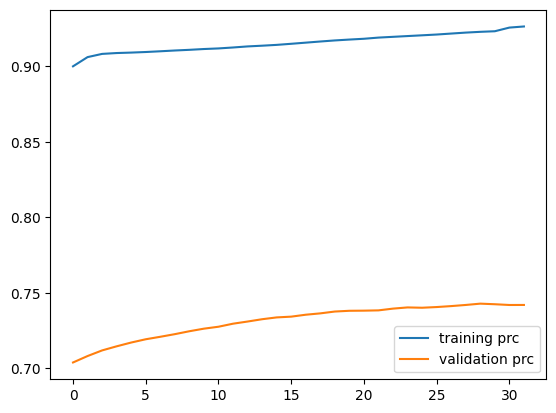

<Figure size 640x480 with 0 Axes>

In [172]:
plt.plot(history_newlr.history["prc"], label="training prc")
plt.plot(history_newlr.history["val_prc"], label="validation prc")
plt.legend()
plt.show()
plt.savefig(os.path.join(peak_selection_result_dir, "train_val_prc.png"))

In [152]:
match model:
    case "cnn":
        cnn_model.save(
            os.path.join(peak_selection_result_dir,
                         "peak_cnn_log_int_cos_dist.keras")
        )
    case "multi_input":
        multi_cnn_model.save(
            os.path.join(peak_selection_result_dir,
                         "peak_cnn_log_int_cos_dist.keras")
        )

# Result Evaluation 
## on testset

In [153]:
cnn_model = tf.keras.models.load_model(
    os.path.join(peak_selection_result_dir, "peak_cnn_log_int_cos_dist.keras")
)

In [154]:
from postprocessing.peak_selection import (
    produce_pred_df,
    plot_pred_distr,
    evaluate_id_based_cls,
)

df_test = produce_pred_df(
    model=multi_cnn_model,
    data=test_dataset_batch,
    label=peak_label_test,
    precursor_id=peak_results_matched_search_range["id"],
    data_idx=test_indices,
)
plot_pred_distr(df_test, peak_selection_result_dir, "log_test_cos_dist")

8/8 [==============================] - 3s 333ms/step


In [155]:
# plot_pred_distr(df_test, peak_selection_result_dir, "log_test_cos_dist")
df_test_filtered = evaluate_id_based_cls(df_test, top_n=1)

Number of precursors without ground truth: 354
Accuracy for top 1 peaks: 0.8416


<Axes: >

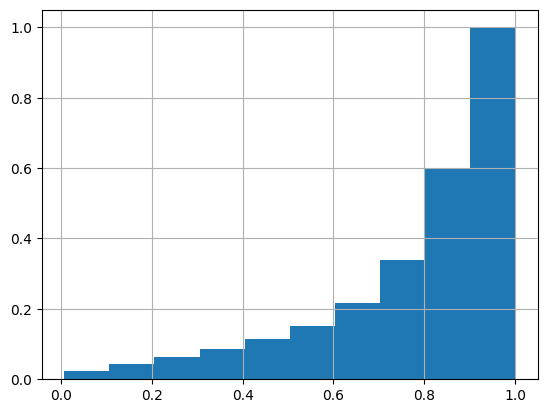

In [156]:
df_test.loc[df_test["y_true"] == 1, "y_pred_prob"].hist(
    cumulative=True, density=1, bins=10
)

In [157]:
df_val = produce_pred_df(
    model=cnn_model,
    data=val_dataset_batch,
    label=peak_label_val,
    precursor_id=peak_results_matched_search_range["id"],
    data_idx=val_indices,
)
plot_pred_distr(df_val, peak_selection_result_dir, "log_val_cos_dist")

4/4 [==============================] - 2s 346ms/step


In [158]:
df_train = produce_pred_df(
    model=cnn_model,
    data=train_dataset.batch(2048, drop_remainder=False),
    label=peak_label_train,
    precursor_id=peak_results_matched_search_range["id"],
    data_idx=train_indices,
)
plot_pred_distr(df_train, peak_selection_result_dir, "log_train_cos_dist")

2024-03-08 15:59:36.154039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 10s 350ms/step


## precursor specific trouble shooting

In [159]:
false_cls = df_test_filtered[df_test_filtered.y_true == 0].precursor_id
true_cls = df_test_filtered[df_test_filtered.y_true == 1].precursor_id

In [160]:
from postprocessing.peak_selection import plot_activation_and_score

for id in true_cls[0:10]:
    plot_activation_and_score(
        peak_results=peak_results_matched_search_range,
        df_test=df_test,
        activation=activation_df,
        cos_dist=cos_dist_df,
        precursor_id=id,
        save_dir=os.path.join(peak_selection_result_dir,
                              "activation_log", "true"),
    )
for id in false_cls[0:10]:
    plot_activation_and_score(
        peak_results=peak_results_matched_search_range,
        df_test=df_test,
        activation=activation_df,
        cos_dist=cos_dist_df,
        precursor_id=id,
        save_dir=os.path.join(peak_selection_result_dir,
                              "activation_log", "false"),
    )

## Full prediction

In [161]:
# For multi input model
dataset = multi_input_generator(
    peak_seq=peak_seq_3d_input, metadata_input=metadata_input, peak_label=peak_label
).batch(2048, drop_remainder=False)

In [162]:
from postprocessing.peak_selection import (
    produce_pred_df,
    get_top_n_scored_peaks_by_precursor,
)


pred_df = produce_pred_df(
    model=multi_cnn_model,
    data=dataset,
    precursor_id=peak_results_matched_search_range.id,
    data_idx=peak_results_matched_search_range.index,
)

peak_results_matched_search_range_pred_score = peak_results_matched_search_range.copy()
peak_results_matched_search_range_pred_score["pred_score"] = pred_df["y_pred_prob"]
pred_df.to_csv(os.path.join(peak_selection_result_dir, "pred_df.csv"))
peak_results_matched_search_range_pred_score.to_csv(
    os.path.join(
        peak_selection_result_dir, "peak_results_matched_search_range_pred_score.csv"
    )
)

2024-03-08 16:00:18.034442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 14s 338ms/step


In [163]:
peak_results_matched_search_range_filtered = (
    peak_results_matched_search_range_pred_score[
        peak_results_matched_search_range_pred_score["pred_score"] >= 0.0
    ]
)

## Compare quant

In [166]:
from postprocessing.peak_selection import get_top_n_scored_peaks_by_precursor

top_1_peak = get_top_n_scored_peaks_by_precursor(
    peak_results_matched_search_range_pred_score,
    top_n=1,
    id_col="id",
    score_col="pred_score",
)
top_1_peak.matched.value_counts(normalize=True)

True     0.754855
False    0.245145
Name: matched, dtype: float64

<Axes: >

AUCActivationPeakCls    18020
dtype: int64

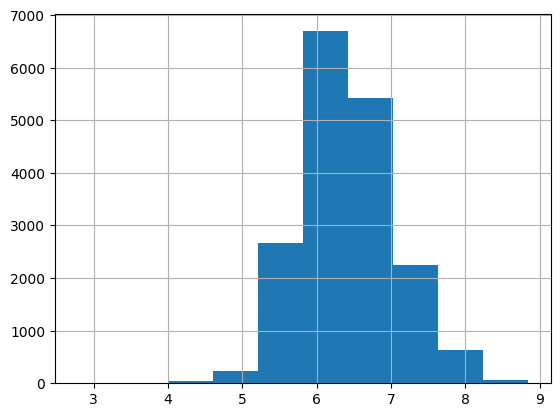

In [167]:
from postprocessing.peak_selection import filter_and_aggregate_intensity

sum_peak_cls = filter_and_aggregate_intensity(
    top_1_peak, threshold=0.0, by_matched=False
)
np.log10(sum_peak_cls.peak_intensity_auc + 1).hist()

sum_peak_cls_aligned = (
    pd.merge(
        left=maxquant_result_ref[["id"]],
        right=sum_peak_cls,
        left_index=True,
        right_on="id",
        how="left",
    )
    .drop(["id", "id_x", "id_y"], axis=1)
    .rename(columns={"peak_intensity_auc": "AUCActivationPeakCls"})
)
sum_peak_cls_aligned.to_csv(os.path.join(peak_selection_result_dir, "sum_peak_cls.csv"))
sum_peak_cls_aligned[sum_peak_cls_aligned > 0].count()

In [168]:
from result_analysis.result_analysis import SBSResult

sbs_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_exp_df=maxquant_result_exp,
    sum_peak=sum_peak_cls_aligned,
    # sum_raw=sum_peak,
)
sbs_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=["full_overlap"],
    handle_mul_exp_pcm="drop",
    save_dir=peak_selection_result_dir,
)
sbs_result.plot_intensity_corr(
    inf_col="AUCActivationPeakCls",
    save_dir=peak_selection_result_dir,
    interactive=False,
    contour=False,
    hover_data=["id"],
)

2024-03-08 16:01:36,891 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64
2024-03-08 16:01:37,106 - result_analysis.compare_maxquant - INFO - Removing 2001 entries with RT_overlap ['full_overlap'], 17185 entries left.
2024-03-08 16:01:37,112 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 17185 -> 17009


Data:  Intensity_log AUCActivationPeakCls_log , slope =  0.842 , intercept =  -0.322 , PearsonR =  0.795 , SpearmanR =  0.781


In [169]:
sbs_result.plot_overlap_with_MQ(show_ref=True, save_dir=peak_selection_result_dir)

/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ref_df_non_zero["precursor"] = self.ref_df_non_zero[
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
